<a href="https://colab.research.google.com/github/caglarsayin/demo/blob/master/whcom_content_updater.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Loading the sheet and converting to do pandas and then converting to JSON

In [1]:
from google.colab import auth
import pandas as pd
import gspread
from google.auth import default
import json

auth.authenticate_user()
creds, _ = default()

gc = gspread.authorize(creds)

worksheet = gc.open_by_key('1Kl_Hy4nVC2PjLSivT46uMrYHhnaFu-kzlFX6OncfK3k').worksheet("Web-Site Input")

# get_all_values gives a list of rows.
rows = worksheet.get_all_records()

# Function to convert column headers from normal text to camelCase
def to_camel_case(text):
    components = text.split()
    return components[0].lower() + ''.join(x.title() for x in components[1:])

data = []
# Load the CSV file to inspect its contents
#file_path = 'candidate.csv'
#data = pd.read_csv(file_path)
data = pd.DataFrame.from_records(rows )

# Apply the camel case function to the columns
data.columns = [to_camel_case(col) for col in data.columns]


# Assuming 'data' is your DataFrame and 'column_name' is the name of your column
data['order'] = pd.to_numeric(data['order'], errors='coerce', downcast='integer')
data['age'] = pd.to_numeric(data['age'], errors='raise', downcast='integer')
data['tenure'] = pd.to_numeric(data['tenure'], errors='raise', downcast='integer')
b = {'TRUE': True, 'FALSE': False}
data["isManager"] = data["isManager"].replace(b)
data["isEu"] = data["isEu"].replace(b)
data["isTechOrProduct"] = data["isTechOrProduct"].replace(b)

# Show the new column names and convert the data to JSON
data.columns, data.head().to_json(orient="records", lines=False, force_ascii=False)


string_candidates = data.to_json(orient="records")

try:
    candidates = json.loads(string_candidates)
    print("JSON data is valid.")
except ValidationError as ve:
    print("Validation error:", ve)

# Display the first few rows of the dataframe
data.head()

JSON data is valid.


,order,profile,jobTitle,jobFamily,department,fullDepartment,profilelink,name,surname,id,...,howWeGiveBack,howWeGiveBackOld,motivationOld,motivationGptNormalized,motivationFinal,isManager,nationality,isEu,countryFlag,isTechOrProduct
0,1,Kaja Mueller,"Director, Employee Identity Governance & Admin...",Security Engineering,Security,Tech - Platform - Global Security DHSE,Kaja Mueller,Kaja,Mueller,Kaja,...,"Mentor, Initiator of WoCo, Electoral Board",Mentoring (3x),I believe a new form of leadership is long due...,It's time for a fresh approach to leadership. ...,,True,German/Polish,True,🇵🇱 🇩🇪,True
1,2,Roman Tuchin,Senior Software Engineer,Software Engineering,Vendor,Vendor Growth - Lifecycle - Vendor Readiness DHSE,Roman Tuchin,Roman,Tuchin,Roman,...,Electoral Board,,Make RTO completely voluntary. Stop ineffectiv...,Let's reimagine the workplace by making Remote...,,False,German/Russian,True,🇷🇺 🇩🇪,True
2,3,Travis Christopher Taylor,Group Product Manager,Product Management,Vendor,International - Ad Tech Awareness & Considerat...,Travis Christopher Taylor,Travis,Taylor,Travis,...,"Workplace Ambassadors, SE Works Council, Initi...","Workplace Ambassadors, SE Works Council",As an SE Works Council member in a mostly-cere...,\nFeeling powerless in a largely symbolic role...,,True,Canadian,False,🇨🇦,True
3,4,Nada Maghraby,Senior Motion Designer,General Marketing,Marketing,Motion Design DHSE,Nada Maghraby,Nada,Magraby,Nada,...,Electoral Board,,Running for the Works Council means making sur...,Running for the Works Council is about amplify...,,False,Egyptian,False,🇪🇬,False
4,5,David Chijioke,Associate Product Manager II,Product Management,Pandora,Pandora Product - Core - Transaction - Order P...,David Chijioke,David C.,Chijioke,David_C,...,Founder and Co-chair Black Heroes,"Founder and Co-chair Black Heroes, empower, su...",to ensure that Diversity needs become balanced...,Ensuring balance in diversity needs is paramou...,,False,Nigerian,False,🇳🇬,True


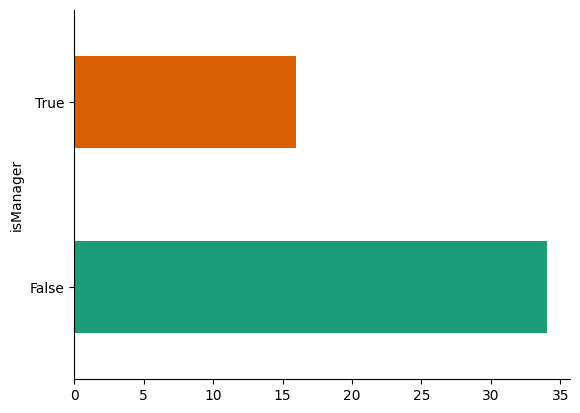

In [ ]:
# @title isManager

from matplotlib import pyplot as plt
import seaborn as sns
data.groupby('isManager').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

Example json item

In [2]:
candidates[0]

{'order': 1,
 'profile': 'Kaja Mueller',
 'jobTitle': 'Director, Employee Identity Governance & Administration',
 'jobFamily': 'Security Engineering',
 'department': 'Security',
 'fullDepartment': 'Tech - Platform - Global Security DHSE',
 'profilelink': 'Kaja Mueller',
 'name': 'Kaja',
 'surname': 'Mueller',
 'id': 'Kaja',
 'age': 40,
 'tenure': 11,
 'jobLevel': 'IC5',
 'communities': 'Women@DH, Parent Heroes',
 'howWeGiveBack': 'Mentor, Initiator of WoCo, Electoral Board',
 'howWeGiveBackOld': 'Mentoring (3x)',
 'motivationOld': 'I believe a new form of leadership is long due. Watching DH was quite frustrating and I knew the only way to change something was to get involved myself. Codetermination and treating employees with the same priority as investors & the business is a must!',
 'motivationGptNormalized': "It's time for a fresh approach to leadership. Witnessing current dynamics has fueled my determination for change. Embracing codetermination and valuing employees as much as inv

Creating the folder if it does not exist and creating jsons with the file name by order id

In [3]:
import os

# Define the path of the directory you want to create
folder_path = '/content/candidates_json'

# Check if the directory exists
if not os.path.exists(folder_path):
    # Create the directory
    os.makedirs(folder_path)

for order, candidate in enumerate(candidates, start=1):
    file_name = f"{folder_path}/{order}.json"
    with open(file_name, 'w', encoding='utf-8') as f:
        json.dump(candidate, f, ensure_ascii=False, indent=4)


Ziping the folder and downloading

In [4]:
!zip -r /content/candidates_json.zip /content/candidates_json
from google.colab import files
files.download("/content/candidates_json.zip")


  adding: content/candidates_json/ (stored 0%)
  adding: content/candidates_json/27.json (deflated 50%)
  adding: content/candidates_json/21.json (deflated 51%)
  adding: content/candidates_json/47.json (deflated 52%)
  adding: content/candidates_json/40.json (deflated 54%)
  adding: content/candidates_json/7.json (deflated 53%)
  adding: content/candidates_json/26.json (deflated 54%)
  adding: content/candidates_json/48.json (deflated 52%)
  adding: content/candidates_json/28.json (deflated 52%)
  adding: content/candidates_json/36.json (deflated 53%)
  adding: content/candidates_json/43.json (deflated 50%)
  adding: content/candidates_json/44.json (deflated 52%)
  adding: content/candidates_json/17.json (deflated 52%)
  adding: content/candidates_json/18.json (deflated 55%)
  adding: content/candidates_json/2.json (deflated 49%)
  adding: content/candidates_json/19.json (deflated 62%)
  adding: content/candidates_json/24.json (deflated 56%)
  adding: content/candidates_json/6.json (d

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading the images from slack

In [ ]:
with open("/content/candidates_slack.json", 'r', encoding='utf-8') as f:
    slack_candidates = json.load(f)["results"]


In [ ]:
slack_candidates[0]

{'id': 'UEHMVBBS8',
 'name': 'alejandro.escobar',
 'deleted': False,
 'color': '4ec0d6',
 'real_name': 'Alejandro Escobar',
 'tz': 'Europe/Amsterdam',
 'tz_label': 'Central European Summer Time',
 'tz_offset': 7200,
 'profile': {'title': 'Senior Data Analyst',
  'phone': '',
  'skype': '',
  'real_name': 'Alejandro Escobar',
  'real_name_normalized': 'Alejandro Escobar',
  'display_name': 'Alejandro Escobar',
  'display_name_normalized': 'Alejandro Escobar',
  'fields': None,
  'status_text': 'Out of office- back on Wed 24th',
  'status_emoji': ':palm_tree:',
  'status_emoji_display_info': [{'emoji_name': 'palm_tree',
    'display_url': 'https://a.slack-edge.com/production-standard-emoji-assets/14.0/apple-large/1f334.png',
    'unicode': '1f334'}],
  'status_expiration': 1713904200,
  'avatar_hash': 'a98eca731ad7',
  'image_original': 'https://avatars.slack-edge.com/2018-12-11/500053434320_a98eca731ad70d88a338_original.jpg',
  'is_custom_image': True,
  'email': 'alejandro.escobar@deli

In [ ]:
from PIL import Image

def convert_jpg_to_png(jpg_file_path, output_file_path):
    with Image.open(jpg_file_path) as image:
        # Ensure the image is in RGB mode
        rgb_image = image.convert('RGB')
        # Save the image in PNG format
        rgb_image.save(output_file_path, "PNG")
        print(f"Image converted and saved as {output_file_path}")


In [ ]:
import requests
def download_image(url, filename):
    response = requests.get(url)
    if response.status_code == 200:  # OK status
        if response.headers["Content-Type"] == "image/png":
            with open(f"{filename}.png", 'wb') as f:
                f.write(response.content)
        elif response.headers["Content-Type"] == "image/jpeg":
            with open(f"tmp.jpg", 'wb') as f:
                f.write(response.content)
            convert_jpg_to_png("tmp.jpg", f"{filename}.png")
    else:
        print("Failed to retrieve image from URL")
    return response

for slack_candidate in slack_candidates:
    try:
        url = slack_candidate["profile"]["image_original"]
        filename = slack_candidate["real_name"].replace(" ", "_")
        filename = filename.replace("_(she/her)", "")
        filename = f"candidates_img/{filename}"
        response = download_image(url, filename)
        print(response.headers["Content-Type"])
    except KeyError:
        print(f'{slack_candidate["name"]} does not have picture')

Image converted and saved as candidates_img/Alejandro_Escobar.png
image/jpeg
Image converted and saved as candidates_img/Alex_Marek.png
image/jpeg
Image converted and saved as candidates_img/Alexandra_Faynveyts.png
image/jpeg
image/png
Image converted and saved as candidates_img/Brenno_Oliveira.png
image/jpeg
image/png
Image converted and saved as candidates_img/Caroline_Wairimu_Kiarie.png
image/jpeg
Image converted and saved as candidates_img/Cindy_Okello.png
image/jpeg
Image converted and saved as candidates_img/David_Chijioke.png
image/jpeg
image/png
Image converted and saved as candidates_img/Evgeniia_Pshenitcyna.png
image/jpeg
Image converted and saved as candidates_img/Evgeniya_Waldner.png
image/jpeg
image/png
image/png
image/png
image/png
Image converted and saved as candidates_img/Hilal_Faizaman.png
image/jpeg
Image converted and saved as candidates_img/Indrajit_Singh.png
image/jpeg
Image converted and saved as candidates_img/Jorge_Rocha.png
image/jpeg
Image converted and saved

In [ ]:
slack_candidate

{'id': 'U1E02NZBL',
 'name': 'kaja',
 'deleted': False,
 'color': '73769d',
 'real_name': 'Kaja Mueller (she/her)',
 'tz': 'Europe/Amsterdam',
 'tz_label': 'Central European Summer Time',
 'tz_offset': 7200,
 'profile': {'title': 'Director, Employee Identity Governance & Administration',
  'phone': '',
  'skype': '',
  'real_name': 'Kaja Mueller (she/her)',
  'real_name_normalized': 'Kaja Mueller (she/her)',
  'display_name': 'Kaja',
  'display_name_normalized': 'Kaja',
  'fields': None,
  'status_text': 'Out sick',
  'status_emoji': ':mask:',
  'status_emoji_display_info': [{'emoji_name': 'mask',
    'display_url': 'https://a.slack-edge.com/production-standard-emoji-assets/14.0/apple-large/1f637.png',
    'unicode': '1f637'}],
  'status_expiration': 0,
  'avatar_hash': 'e792945f24af',
  'image_original': 'https://s3-us-west-2.amazonaws.com/slack-files2/avatars/2024-02-27/6702211288678_e792945f24af727baeb9_original.jpg',
  'is_custom_image': True,
  'email': 'katarzyna.mueller@delivery

In [ ]:
!zip -r /content/candidates_img.zip /content/candidates_img
from google.colab import files
files.download("/content/candidates_img.zip")

updating: content/candidates_img/ (stored 0%)
updating: content/candidates_img/David_Chijioke.png (deflated 0%)
updating: content/candidates_img/Kolawole_Popoola.png (deflated 1%)
updating: content/candidates_img/Torsten_Pfahl.png (deflated 0%)
updating: content/candidates_img/Vincent_Alsteen.png (deflated 1%)
updating: content/candidates_img/Evgeniya_Waldner.png (deflated 0%)
updating: content/candidates_img/Shrawan_Adhikari.png (deflated 0%)
updating: content/candidates_img/Brenno_Oliveira.png (deflated 0%)
updating: content/candidates_img/Lorna_Ather.png (deflated 0%)
updating: content/candidates_img/Kishlay_Kumar.png (deflated 0%)
updating: content/candidates_img/Nora_Sternmann.png (deflated 0%)
updating: content/candidates_img/Svetlana_Lanets.png (deflated 0%)
updating: content/candidates_img/Gustavo_Amado.png (deflated 0%)
updating: content/candidates_img/Luísa_Ribeiro.png (deflated 0%)
updating: content/candidates_img/Mariana_Solana_Ros.png (deflated 0%)
updating: content/candid

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>